In [172]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
from mne_icalabel import label_components
# fastica, picard, infomax. Picard maybe better

In [308]:
# Select file from measurement
# Change next to lines if needed
path = "C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/"
filename = "EEGdata-2024-156--14-35-07"

df = pd.read_csv(path+filename + ".csv", sep=",")
end = df.shape[0]-5 # Remove 5 samples buffer at the end
fs = 250
df = df.iloc[:end, :8] # Select 72000 samples from 8 channels
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,223617.953125,250089.921875,298469.375000,307365.18750,219274.562500,248116.984375,208150.546875,236444.906250
1,223641.109375,250036.375000,298319.625000,307372.00000,219078.937500,248037.593750,208076.328125,236387.953125
2,223711.375000,250304.140625,299091.843750,307504.40625,219779.265625,248456.281250,208445.859375,236724.203125
3,223730.250000,250525.156250,299727.781250,307579.34375,220415.750000,248797.375000,208747.953125,236991.796875
4,223669.531250,250386.312500,299322.062500,307483.12500,220089.953125,248578.328125,208558.062500,236811.828125
...,...,...,...,...,...,...,...,...
71995,225653.750000,250691.359375,260456.578125,269237.87500,221237.843750,248687.125000,208144.734375,236301.937500
71996,225611.640625,250457.203125,259665.062500,269138.34375,220502.468750,248296.515625,207752.671875,235978.281250
71997,225619.687500,250378.796875,259386.281250,269130.40625,220211.718750,248149.250000,207606.500000,235871.531250
71998,225666.531250,250566.546875,260020.265625,269224.81250,220777.937500,248458.515625,207912.984375,236130.906250


In [309]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 2
    highcut = 30
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(8, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # import scipy.signal as signal

    # Define the notch filter parameters
    fs = 250  # Sampling frequency
    f0 = 50  # Notch frequency
    Q = 1 # Quality factor

    # Design the notch filter
    b, a = signal.iirnotch(f0, Q, fs)

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    return df_filt1

In [310]:
#Apply the filters and DC component removal
df = filter(df)

In [311]:
# Constants
num_components = 8
allOutputs = df

channels = df.T

# create mne_info object
ch_names =        ['Fz', 
            'C3',  'Cz',  'C4', 
                   'Pz', 
            'PO7', 'Oz',  'PO8']

ch_type = ['eeg' for i in range(8)]
mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

#create mne.raw object
raw = mne.io.RawArray(channels, mne_info)
raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

Creating RawArray with float64 data, n_channels=8, n_times=72000
    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [312]:
#actual code
raw.filter(2, 30)

# ICA model
ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
#ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
ica.fit(raw) # fit the model on the data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.6s.


Method,picard
Fit parameters,ortho=Falseextended=Truemax_iter=500
Fit,32 iterations on raw data (72000 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [313]:
# assuming you have a Raw and ICA instance previously fitted
labels = label_components(raw, ica, method='iclabel')

# Find the channels which have a probability of less than 0.9
print("Potential bad channels: \n",np.where(labels['y_pred_proba'][labels['y_pred_proba'] < 0.80])[0])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\JackC\AppData\Local\Temp\ipykernel_8912\3864828568.py:2: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')
C:\Users\JackC\AppData\Local\Temp\ipykernel_8912\3864828568.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')


Potential bad channels: 
 [0]


Creating RawArray with float64 data, n_channels=8, n_times=72000
    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


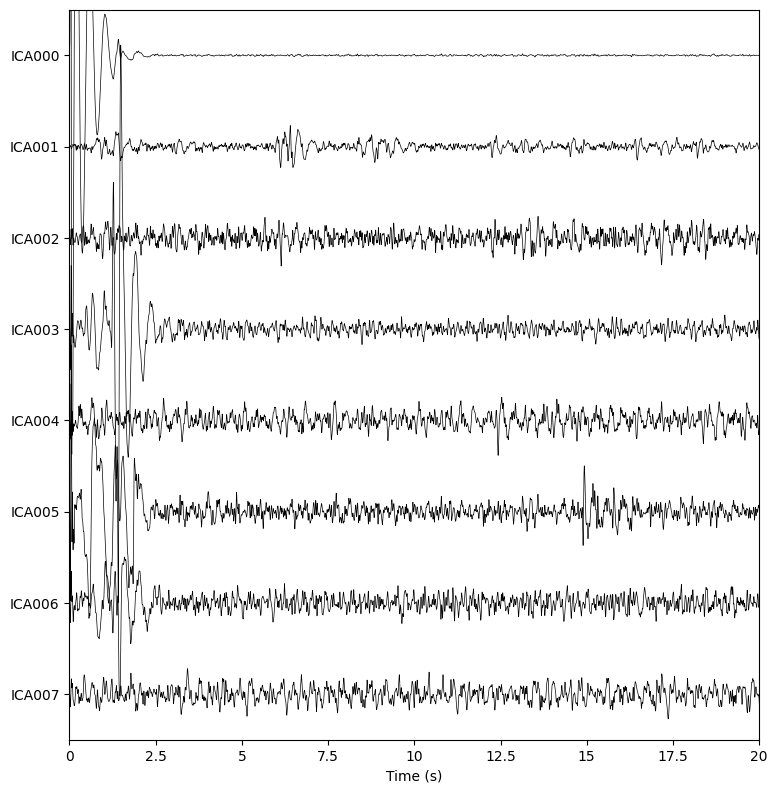

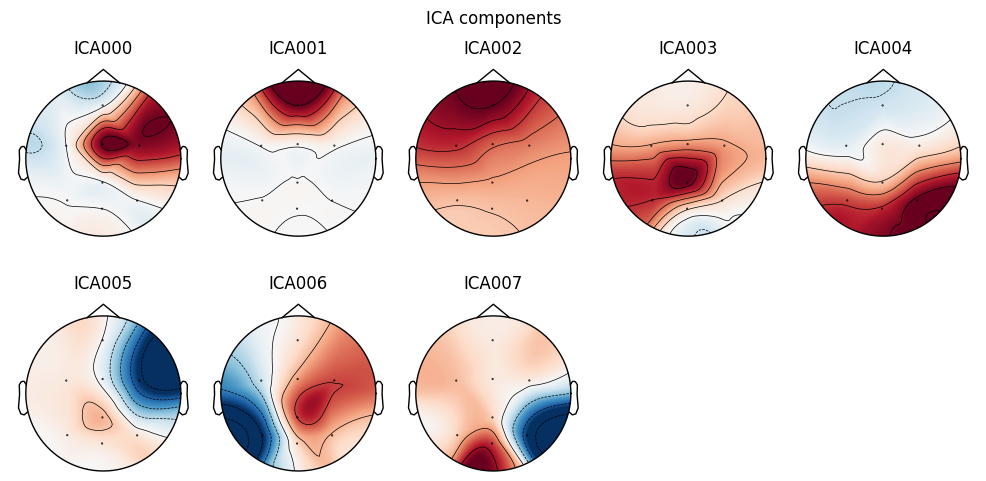

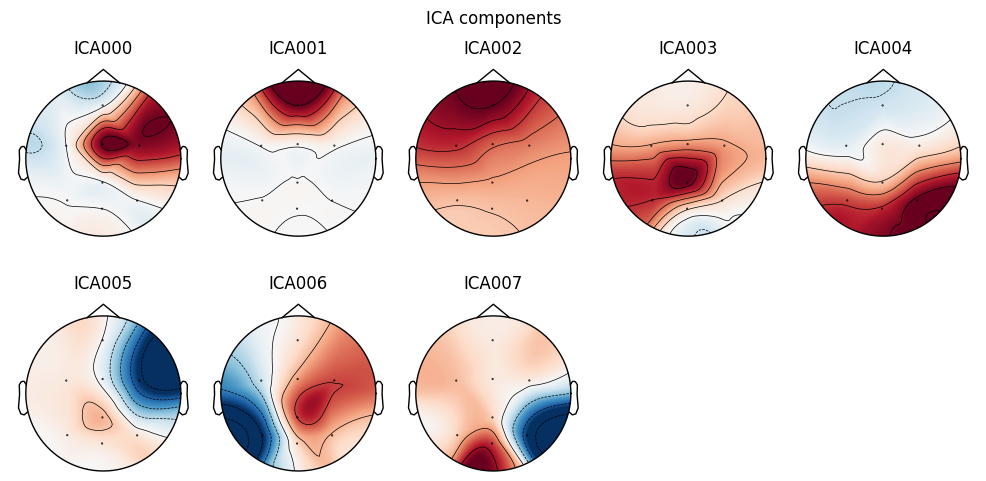

In [314]:
# Plot the raw data channels and also the ICA signal components
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_components(picks=range(num_components), ch_type='eeg')


Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


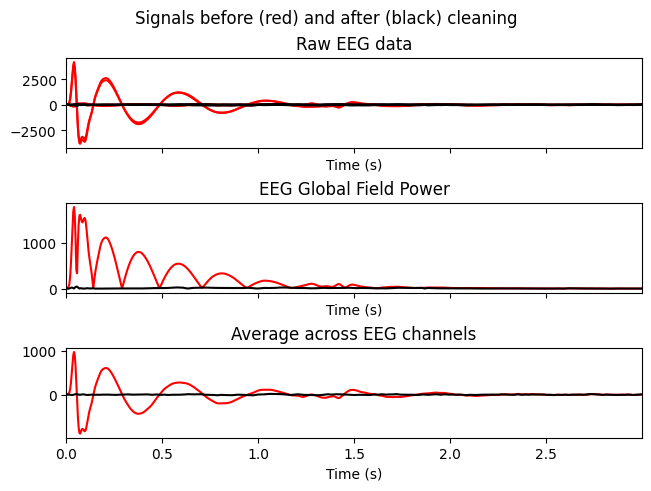

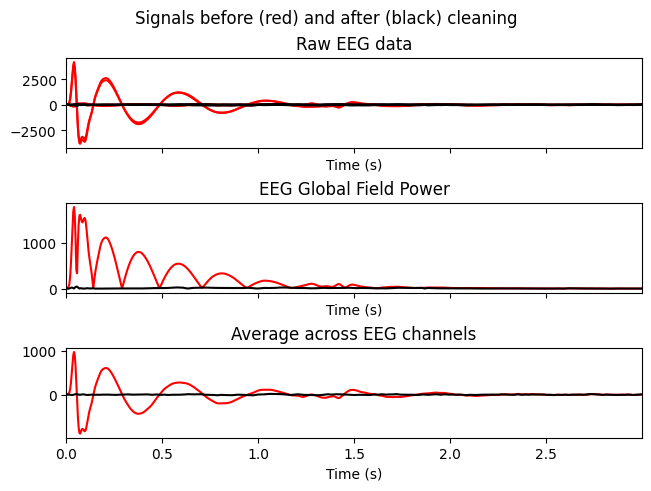

In [315]:
# ICA plot overlay to see difference when excluding
ica.plot_overlay(raw, exclude=[0,3], picks="eeg")

In [316]:
#ica.plot_properties(raw, picks=[0, 1])

In [326]:
# Change the indices which needs to be removed based on the plots and bad channels
ica.exclude = [0,1,3]  # indices chosen based on various plots above

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


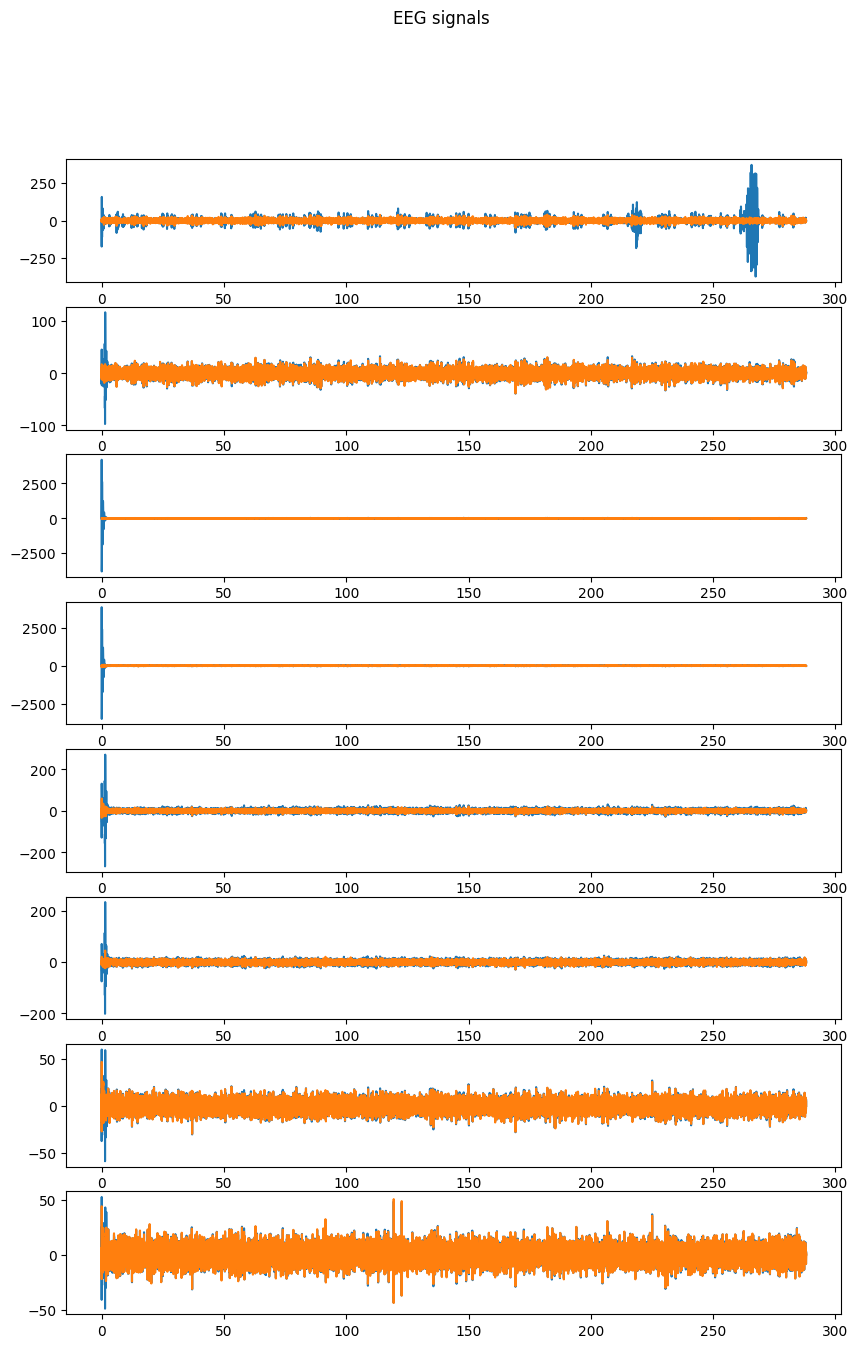

In [327]:
# Transpose to recreate the original shape
raw_array = raw[:][0].T
reconst_raw_array = reconst_raw[:][0].T

# plot the original and ICA filtered signal
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,raw_array[:,i])
    axs[i].plot(x1,reconst_raw_array[:,i])

plt.show()

In [328]:
# Convert ICA signal to csv file
ICA_data = pd.DataFrame(reconst_raw_array)
ICA_data.to_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/" +filename + "_ICA.csv", index = False)